In [94]:
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import pipeline

In [95]:
# Load the Dataset
df = pd.read_csv('train.csv')

# Display the first few rows of the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

In [96]:
# Dropping the price range coloumn form datasheet and storing it in X
X  = df.drop('price_range', axis = 1).values
# Storing the price range coloumn in y
y  = df['price_range'].values

# Bayesian optimization

In [97]:
# optimization function for hyperparameter optimization using Bayesian optimisation
def optimize(params, param_names, x, y, list_of_all_params):
    print(params, param_names)
    # storing all set of parameters values(params) in a list
    list_of_all_params.append(params)
    #converting params(list) in to params(dictionary)
    params = dict(zip(param_names, params))  #this will not work if we are tuning the params of different models
    model  = ensemble.RandomForestClassifier(**params, n_jobs=-1, random_state=42) #unpacing of params dict into parameters of RandomForestClassifier
    kf     = model_selection.StratifiedKFold(n_splits = 5)

    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]

        xtrain = x[train_idx]
        ytrain = y[train_idx]
        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)

        accuracies.append(fold_acc)

    return -1*np.mean(accuracies)

In [98]:
from functools import partial
from skopt import space
from skopt import gp_minimize

In [99]:
# Initialize a search space of max_depth, n_estimators, criterion and max_features
param_space = [
    space.Integer(3, 15, name="max_depth"),
    space.Integer(100, 600, name="n_estimators"),
    space.Categorical(["gini", "entropy"], name="criterion"),
    space.Real(0.01, 1, prior = "uniform", name="max_features")
]

In [100]:
param_names  = ["max_depth", "n_estimators", "criterion", "max_features" ]
param_names

['max_depth', 'n_estimators', 'criterion', 'max_features']

In [101]:
#Creating a list to store all set of params value of each iteration
list_of_all_params = []
optimization_func = partial(optimize, param_names = param_names, x = X, y = y, list_of_all_params = list_of_all_params)

In [102]:
# storing the best parameters in result
result = gp_minimize(optimization_func, dimensions = param_space, n_calls = 15, n_random_starts = 10, verbose = 10)

Iteration No: 1 started. Evaluating function at random point.
[6, 532, 'entropy', 0.17750188714355203] ['max_depth', 'n_estimators', 'criterion', 'max_features']
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 13.8131
Function value obtained: -0.8395
Current minimum: -0.8395
Iteration No: 2 started. Evaluating function at random point.
[3, 310, 'entropy', 0.9007568482553305] ['max_depth', 'n_estimators', 'criterion', 'max_features']
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.6109
Function value obtained: -0.7650
Current minimum: -0.8395
Iteration No: 3 started. Evaluating function at random point.
[5, 335, 'gini', 0.8451888042739593] ['max_depth', 'n_estimators', 'criterion', 'max_features']
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 9.1605
Function value obtained: -0.8700
Current minimum: -0.8700
Iteration No: 4 started. Evaluating function at random point.
[14, 142, 'entropy', 0.9300766632402941] ['max_depth', '

In [103]:
print(list_of_all_params)
print(len(list_of_all_params))

[[6, 532, 'entropy', 0.17750188714355203], [3, 310, 'entropy', 0.9007568482553305], [5, 335, 'gini', 0.8451888042739593], [14, 142, 'entropy', 0.9300766632402941], [11, 493, 'entropy', 0.47584290920523103], [6, 419, 'gini', 0.6556244826938277], [7, 385, 'entropy', 0.39591778345377104], [12, 217, 'entropy', 0.5127087994361123], [6, 450, 'entropy', 0.7207320484779698], [13, 497, 'gini', 0.9597927574379043], [15, 100, 'entropy', 0.01], [8, 100, 'entropy', 1.0], [7, 456, 'entropy', 0.8537050724550479], [10, 100, 'entropy', 0.6055973936204752], [15, 100, 'entropy', 1.0]]
15


In [ ]:
print(result)

In [105]:
#Printing the set of best hyperparameter values in dictionary format
print(dict(zip(param_names, result.x)))

{'max_depth': 12, 'n_estimators': 217, 'criterion': 'entropy', 'max_features': 0.5127087994361123}


In [106]:
# storing the best values in a list
best_params = result.x
print(best_params)

[12, 217, 'entropy', 0.5127087994361123]


In [107]:
#setting the best hyperparameter values in the classifier
classifier = ensemble.RandomForestClassifier(criterion =best_params[2], max_depth = int(best_params[0]), n_estimators = int(best_params[1]),
                                             max_features = float(best_params[3]), n_jobs=-1, random_state=42)


In [108]:
from sklearn.model_selection import cross_val_score

# Calculation of the cross validation score
score = cross_val_score(classifier,X,y, cv=10)
print('scores\n',score)
print('\ncv values', score.shape)
print('\nScore_Mean', score.mean())

scores
 [0.92  0.92  0.92  0.915 0.915 0.935 0.89  0.91  0.885 0.9  ]

cv values (10,)

Score_Mean 0.9110000000000001


In [109]:
from sklearn.model_selection import train_test_split

In [110]:
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.2)

In [111]:
scaling_x = [i for i in range(1, 16, 1)]
print(scaling_x)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [112]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(criterion =best_params[2], max_depth = int(best_params[0]), n_estimators = int(best_params[1]),
                                             max_features = float(best_params[3]), n_jobs=-1, random_state=42)

In [113]:
from sklearn import metrics
import numpy as np
from sklearn.metrics import roc_auc_score

# Example data (replace with your actual data)
classifier.fit(x_train, y_train)

y_score =  classifier.predict_proba(x_test)  # Predicted probabilities for all classes
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print("ROC AUC (One-vs-Rest):", roc_auc)

ROC AUC (One-vs-Rest): 0.9886230427185418


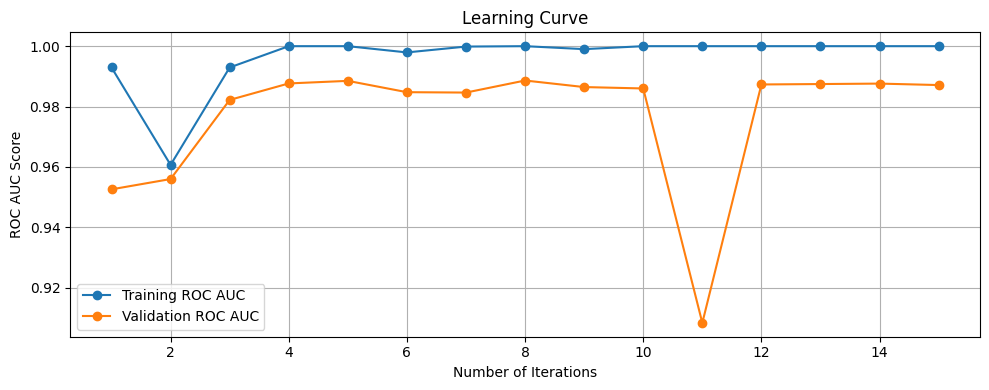

In [114]:
# Plot of the Learning Rate Distribution Curve
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

# Creating a list for storing all train ROC Scores
train_scores = []
#Creating a list for storing all Validation ROC Scores
val_scores = []
#Creating a list for storing all Validation ROC Scores for Bayesian optimization for further comparison w.r.t hyperopt optimization
roc_score_BO = []
for para in list_of_all_params:
    # Initialize classifier with current n_estimators
    classifier = RandomForestClassifier(criterion =para[2], max_depth = int(para[0]), n_estimators = int(para[1]),
                                             max_features = float(para[3]), n_jobs=-1, random_state=42)

    # Train the classifier
    classifier.fit(x_train, y_train)

    # Predict probabilities for ROC AUC calculation
    y_train_score = classifier.predict_proba(x_train)
    y_val_score = classifier.predict_proba(x_test)

    # Compute ROC AUC scores
    train_roc_auc = roc_auc_score(y_train, y_train_score, multi_class='ovr')
    val_roc_auc = roc_auc_score(y_test, y_val_score, multi_class='ovr')

    # Store scores
    train_scores.append(train_roc_auc)
    val_scores.append(val_roc_auc)
    roc_score_BO.append(val_roc_auc)


# Plotting the learning curves
plt.figure(figsize=(10, 4))
plt.plot(scaling_x, train_scores, marker='o', label='Training ROC AUC')
plt.plot(scaling_x, val_scores, marker='o', label='Validation ROC AUC')
plt.xlabel('Number of Iterations')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Random Forest (Random Hyperparameters value)

In [134]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.offline import iplot , plot
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [135]:
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.2)

In [136]:
model_RFC = RandomForestClassifier(n_estimators=10,n_jobs=-1, random_state=42)
model_RFC.fit(x_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [137]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [138]:
from sklearn import metrics
import numpy as np
from sklearn.metrics import roc_auc_score

# Example data (replace with your actual data)

y_score = model_RFC.predict_proba(x_test)  # Predicted probabilities for all classes
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print("ROC AUC (One-vs-Rest):", roc_auc)


ROC AUC (One-vs-Rest): 0.9422483675581909


In [139]:
# Perform 10-fold cross-validation
score = cross_val_score(model_RFC, X, y, cv=10)

# Print the scores
print('scores\n', score)

# Print the shape of the scores array
print('\ncv values', score.shape)

# Print the mean score
print('\nScore_Mean', score.mean())

scores
 [0.795 0.805 0.83  0.79  0.83  0.795 0.78  0.86  0.79  0.78 ]

cv values (10,)

Score_Mean 0.8055


# hyperopt

In [121]:
from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope

In [122]:
# Optimization Function for obtaining best hyperparameter values.
def optimize(params, x, y, list_of_all_params_hyperopt):
    #storing the list of set of hyperparameters values in each iteration
    list_of_all_params_hyperopt.append(list(params.values()));
    model = ensemble.RandomForestClassifier(**params,n_jobs=-1, random_state=42)
    kf = model_selection.KFold(n_splits=5)
    accuracies = []
    for idx in kf.split(X=x, y=y):
        train_idx, test_idx = idx[0], idx[1]
        xtrain = x[train_idx]
        ytrain = y[train_idx]

        xtest = x[test_idx]
        ytest = y[test_idx]

        model.fit(xtrain, ytrain)
        preds = model.predict(xtest)
        fold_acc = metrics.accuracy_score(ytest, preds)
        accuracies.append(fold_acc)

    return -1.0 * np.mean(accuracies)

In [123]:
#Defining the range of hyperparameters values
param_space = {
    "max_depth": scope.int(hp.quniform("max_depth", 3, 15, 1)),
    "n_estimators": scope.int(hp.quniform("n_estimators", 100, 600, 1)),
    "criterion": hp.choice("criterion", ["gini", "entropy"]),
    "max_features": hp.uniform("max_features", 0.01, 1)
}
# Creating a list to store all set/list of hyperparameters values
list_of_all_params_hyperopt=[]
optimization_function = partial(
    optimize,
    x=X,
    y=y,
    list_of_all_params_hyperopt=list_of_all_params_hyperopt
)

trials = Trials() # It would be nice to see exactly what is happening inside the hyperopt black box. The Trials object allows us to do just that.

result = fmin(
    fn=optimization_function,
    space=param_space,
    algo=tpe.suggest,
    max_evals=15,
    trials=trials,
)

print(result)

100%|██████████| 15/15 [03:17<00:00, 13.18s/trial, best loss: -0.906]
{'criterion': 1, 'max_depth': 13.0, 'max_features': 0.8162855192816482, 'n_estimators': 592.0}


In [124]:
print(list_of_all_params_hyperopt)

[['gini', 14, 0.1322571218423532, 376], ['gini', 9, 0.8327273771699873, 232], ['entropy', 6, 0.24177490462307846, 457], ['entropy', 14, 0.8342129578627616, 248], ['gini', 6, 0.8052829996808377, 234], ['entropy', 10, 0.6189655756317284, 369], ['entropy', 14, 0.8883895194898679, 171], ['entropy', 13, 0.8162855192816482, 592], ['gini', 11, 0.10464068431376523, 513], ['entropy', 3, 0.6333199329129594, 503], ['entropy', 7, 0.8626314751958779, 569], ['gini', 10, 0.6626603652845969, 374], ['gini', 14, 0.7426076807410158, 164], ['entropy', 10, 0.3047838187479377, 587], ['entropy', 9, 0.3833165909968004, 458]]


In [127]:
# Print the optimized  hyperparameters
print("optimized  hyperparameters:", result)

optimized  hyperparameters: {'criterion': 1, 'max_depth': 13.0, 'max_features': 0.8162855192816482, 'n_estimators': 592.0}


In [126]:
# Train the model with the result/optimized  hyperparameters
best_params = {
    'max_depth': int(result['max_depth']),
    'n_estimators': int(result['n_estimators']),
    'criterion': ['gini', 'entropy'][result['criterion']],
    'max_features': result['max_features']
}


In [129]:
# Train the model with the best hyperparameters
best_clf = RandomForestClassifier(**best_params, n_jobs=-1, random_state=42)
cross_val_scores = cross_val_score(best_clf, X, y, scoring='accuracy', cv=5)

In [130]:
# Evaluation of the ROC-AUC score for the optimized hyperparameters
best_clf.fit(x_train, y_train)

y_score =  best_clf.predict_proba(x_test)  # Predicted probabilities for all classes
roc_auc = roc_auc_score(y_test, y_score, multi_class='ovr')
print("ROC AUC (One-vs-Rest):", roc_auc)

ROC AUC (One-vs-Rest): 0.9910524443598764


In [131]:

# Print the cross-validation scores
print("Cross-validation scores:", cross_val_scores)
print("Mean cross-validation score:", cross_val_scores.mean())

Cross-validation scores: [0.9125 0.925  0.9075 0.8925 0.9   ]
Mean cross-validation score: 0.9075000000000001


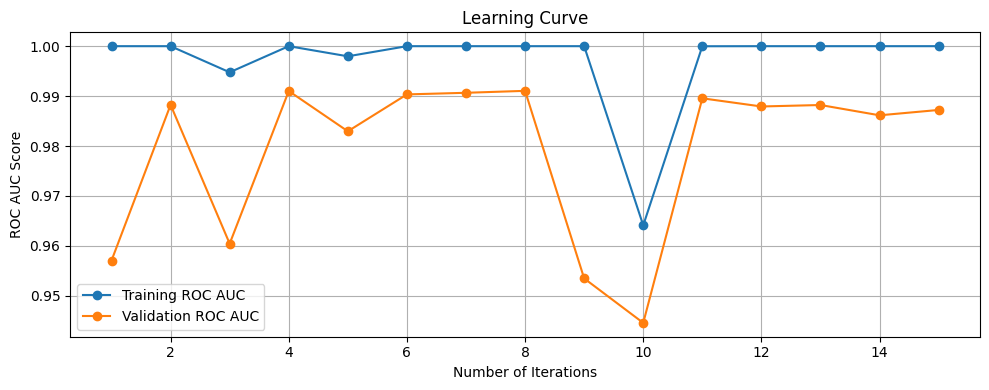

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

train_scores = []
val_scores = []
roc_score_hyperopt = []
for para in list_of_all_params_hyperopt:
    # Initialize classifier with current n_estimators
    classifier = RandomForestClassifier(criterion =para[0], max_depth = int(para[1]), n_estimators = int(para[3]),
                                             max_features = float(para[2]), n_jobs=-1, random_state=42)

    # Train the classifier
    classifier.fit(x_train, y_train)

    # Predict probabilities for ROC AUC calculation
    y_train_score = classifier.predict_proba(x_train)
    y_val_score = classifier.predict_proba(x_test)

    # Compute ROC AUC scores
    train_roc_auc = roc_auc_score(y_train, y_train_score, multi_class='ovr')
    val_roc_auc = roc_auc_score(y_test, y_val_score, multi_class='ovr')

    # Store scores
    train_scores.append(train_roc_auc)
    val_scores.append(val_roc_auc)
    roc_score_hyperopt.append(val_roc_auc)
# Plotting the learning curves
plt.figure(figsize=(10, 4))
plt.plot(scaling_x, train_scores, marker='o', label='Training ROC AUC')
plt.plot(scaling_x, val_scores, marker='o', label='Validation ROC AUC')
plt.xlabel('Number of Iterations')
plt.ylabel('ROC AUC Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# Learning Rate Distribution Curve Comparison Of Bayesian optimisation & Hyperopt

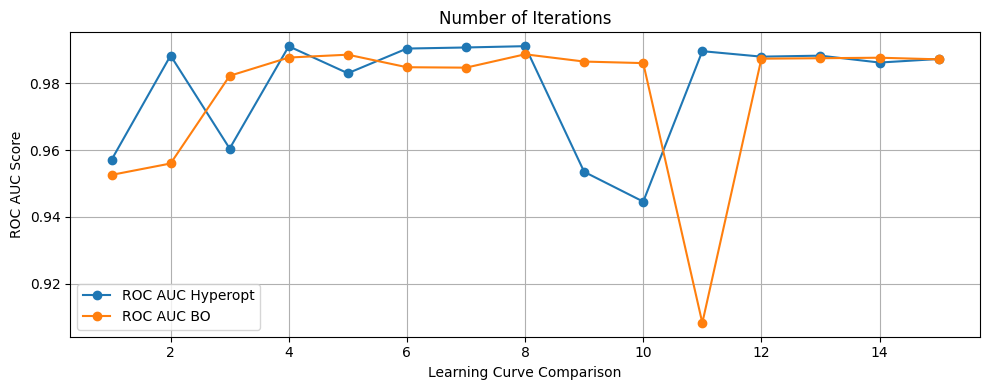

In [133]:
plt.figure(figsize=(10, 4))
plt.plot(scaling_x, roc_score_hyperopt, marker='o', label='ROC AUC Hyperopt')
plt.plot(scaling_x, roc_score_BO, marker='o', label='ROC AUC BO')
plt.xlabel('Learning Curve Comparison')
plt.ylabel('ROC AUC Score')
plt.title('Number of Iterations')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()